# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
print(feat_info.shape)
feat_info

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
tmp = azdias.isnull().sum()
print("Number of naturally missing values by feature")
print('---------------------------------------------')
print(tmp[tmp!=0])
print('---------------------------------------------')
print("Total number of naturally missing values: {}".format(azdias.isnull().sum().sum()))

Number of naturally missing values by feature
---------------------------------------------
CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_AN

In [8]:
for ii, key in enumerate(feat_info['attribute']):
    missing_or_unknown = feat_info['missing_or_unknown'][ii]
    missing_or_unknown = missing_or_unknown[1:-1].split(',') # returns a list of strings
    
    if missing_or_unknown[0]: # make sure missing_or_unknown contains something; '' will be skipped
        if azdias[key].dtype == 'int64':
            missing_or_unknown = [int(x) for x in missing_or_unknown]
        elif azdias[key].dtype == 'float64':
            missing_or_unknown = [float(x) for x in missing_or_unknown]
        elif azdias[key].dtype == 'O':
            pass # do not convert the type for string variables
        else: 
            print("Warning: unknown data type")    
        
        azdias.loc[azdias[key].isin(missing_or_unknown), key] = np.nan

In [9]:
# missing values after conversion
print("Total number of naturally missing values: {}".format(azdias.isnull().sum().sum()))

Total number of naturally missing values: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_percentage = round(azdias.isnull().mean() * 100,2)
missing_percentage.sort_values(ascending = False)

TITEL_KZ                 99.76
AGER_TYP                 76.96
KK_KUNDENTYP             65.60
KBA05_BAUMAX             53.47
GEBURTSJAHR              44.02
ALTER_HH                 34.81
REGIOTYP                 17.74
KKK                      17.74
W_KEIT_KIND_HH           16.61
KBA05_ANTG4              14.96
KBA05_GBZ                14.96
MOBI_REGIO               14.96
KBA05_ANTG1              14.96
KBA05_ANTG2              14.96
KBA05_ANTG3              14.96
PLZ8_GBZ                 13.07
PLZ8_HHZ                 13.07
PLZ8_BAUMAX              13.07
PLZ8_ANTG4               13.07
PLZ8_ANTG1               13.07
PLZ8_ANTG3               13.07
PLZ8_ANTG2               13.07
SHOPPER_TYP              12.48
VERS_TYP                 12.48
HEALTH_TYP               12.48
NATIONALITAET_KZ         12.15
PRAEGENDE_JUGENDJAHRE    12.14
KBA13_ANZAHL_PKW         11.87
ANZ_HAUSHALTE_AKTIV      11.18
CAMEO_INTL_2015          11.15
                         ...  
LP_STATUS_FEIN            0.54
LP_STATU

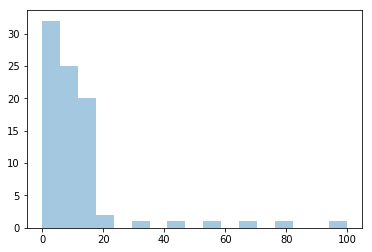

In [11]:
# Investigate patterns in the amount of missing data in each column.
sb.distplot(missing_percentage, kde=False)

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
rm_list = missing_percentage[missing_percentage > 20].index
print(rm_list)

azdias.drop(rm_list, axis = 1, inplace = True)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [13]:
# azdias.info()
# azdias.describe()

#### Discussion 1.1.2: Assess Missing Data in Each Column

It seems the discontinuity occurs when the missing rate is greater than 20%. So I dropped the following 6 features whose missing rate is larger than 20%, with a minimum of 34.81% and a maximum of 99.76%.

- TITEL_KZ                 99.76
- AGER_TYP                 76.96
- KK_KUNDENTYP             65.60
- KBA05_BAUMAX             53.47
- GEBURTSJAHR              44.02
- ALTER_HH                 34.81

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
missing_percentage_row = azdias.isnull().mean(axis = 1) * 100
missing_percentage_row.describe()

count    891221.000000
mean          7.151764
std          16.752768
min           0.000000
25%           0.000000
50%           0.000000
75%           3.797468
max          62.025316
dtype: float64

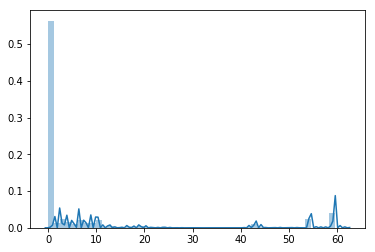

In [15]:
sb.distplot(missing_percentage_row)

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# it seems 30% is natural cut-off

azdias_a30 = azdias[missing_percentage_row >= 30]
azdias_b30 = azdias[missing_percentage_row <  30]

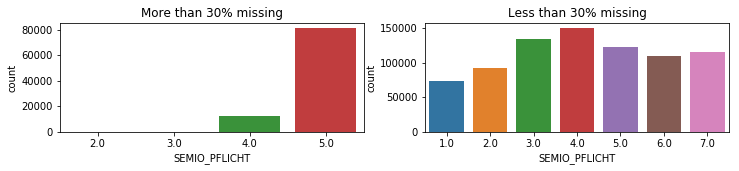

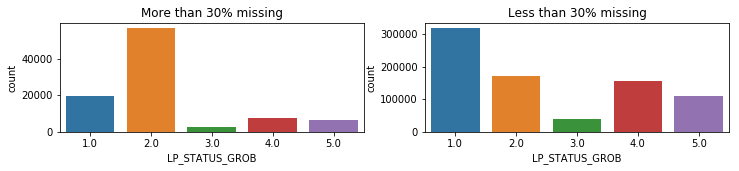

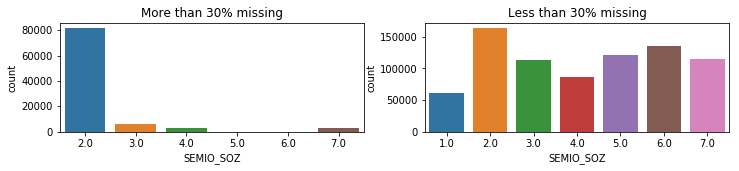

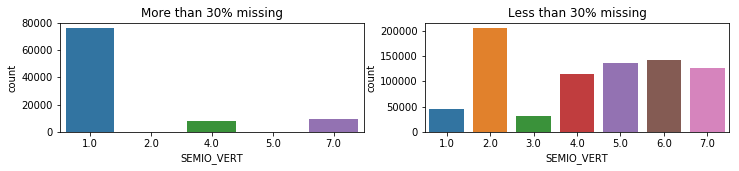

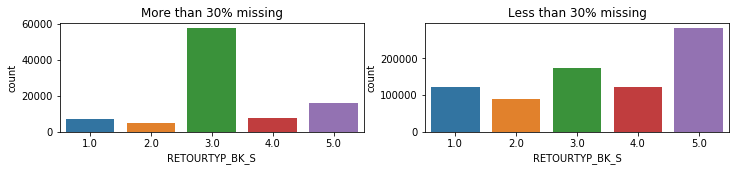

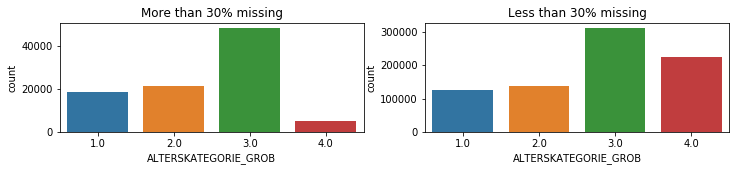

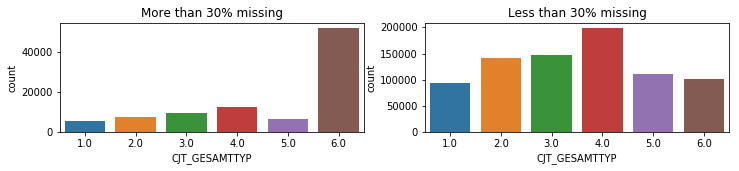

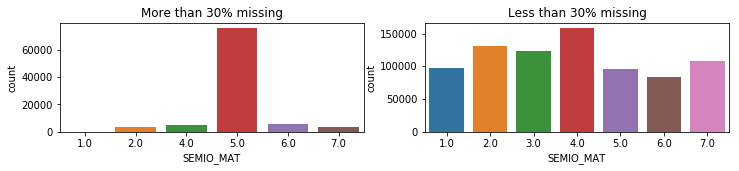

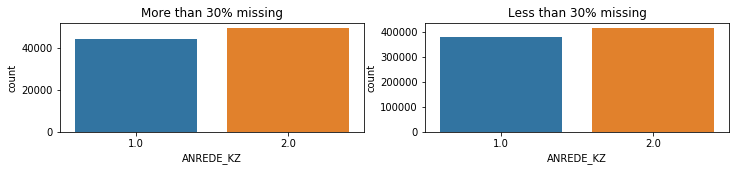

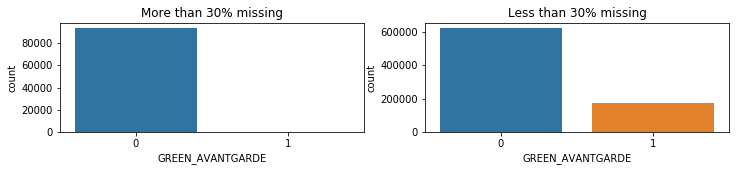

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

col_list = missing_percentage.sort_values().head(30).sample(10, random_state=0).index

for col in col_list:
    fig = plt.figure(figsize=(12,2))
    
    ax = fig.add_subplot(1,2,1)
    sb.countplot(azdias_a30[col])
    ax.set(title='More than 30% missing')
    
    ax = fig.add_subplot(1,2,2)
    sb.countplot(azdias_b30[col])
    ax.set(title='Less than 30% missing')

In [18]:
[x for x in col_list]

['SEMIO_PFLICHT',
 'LP_STATUS_GROB',
 'SEMIO_SOZ',
 'SEMIO_VERT',
 'RETOURTYP_BK_S',
 'ALTERSKATEGORIE_GROB',
 'CJT_GESAMTTYP',
 'SEMIO_MAT',
 'ANREDE_KZ',
 'GREEN_AVANTGARDE']

#### Discussion 1.1.3: Assess Missing Data in Each Row

Yes, for variables such as 'SEMIO_PFLICHT', 'LP_STATUS_GROB', 'SEMIO_SOZ', and 'SEMIO_VERT', the distributions are very different. It seems the group of people with more missing values are a different group of people than those with less missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
feat_info_updated = feat_info[~feat_info['attribute'].isin(rm_list)]
feat_info_updated['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_features = feat_info_updated[feat_info_updated["type"] == "categorical"]["attribute"]
cat_features

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.
binary_flist = []
multi_flist  = []

for fea in cat_features:
    if len(azdias_b30[fea].value_counts()) == 2:
        binary_flist.append(fea)
    else:
        multi_flist.append(fea)
        
print('binary:    ', binary_flist)
print('multilevel:', multi_flist)

binary:     ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
multilevel: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [22]:
azdias_clean = azdias_b30.copy()

for fea in binary_flist:
    azdias_clean[fea].replace(azdias_b30[fea].value_counts().index, [0,1], inplace = True)

# drop multi-level categorical features
azdias_clean.drop(multi_flist, axis=1, inplace = True)

azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797837 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     795037 non-null float64
ANREDE_KZ                797837 non-null float64
FINANZ_MINIMALIST        797837 non-null float64
FINANZ_SPARER            797837 non-null float64
FINANZ_VORSORGER         797837 non-null float64
FINANZ_ANLEGER           797837 non-null float64
FINANZ_UNAUFFAELLIGER    797837 non-null float64
FINANZ_HAUSBAUER         797837 non-null float64
GREEN_AVANTGARDE         797837 non-null int64
HEALTH_TYP               761193 non-null float64
LP_LEBENSPHASE_FEIN      747827 non-null float64
LP_LEBENSPHASE_GROB      750707 non-null float64
PRAEGENDE_JUGENDJAHRE    769164 non-null float64
RETOURTYP_BK_S           793171 non-null float64
SEMIO_SOZ                797837 non-null float64
SEMIO_FAM                797837 non-null float64
SEMIO_REL                797837 non-null float64
SEMIO_MAT                797837 non-null float64
SEMIO_VER

In [23]:
azdias_clean['CAMEO_INTL_2015'].value_counts()

51    133691
41     92336
24     91145
14     62877
43     56669
54     45388
25     39619
22     33146
23     26728
13     26330
45     26132
55     23953
52     20542
31     19009
34     18522
15     16974
44     14820
12     13244
35     10355
32     10354
33      9934
Name: CAMEO_INTL_2015, dtype: int64

In [24]:
azdias_clean['CAMEO_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].apply(float)

#### Discussion 1.2.1: Re-Encode Categorical Features

I did the following in this section:

- Re-encode all binary categorical features into dummy 0-1 valued dummies.
- Discard all other categorical features which have more than 2 levels/values.
- Feature 'CAMEO_INTL_2015' was in string format but had all numerical values. I tranformed it into float format.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# azdias_clean['PRAEGENDE_JUGENDJAHRE'].value_counts()
decade_map   = {1:1, 2:1, 
                3:2, 4:2, 
                5:3, 6:3, 7:3, 
                8:4, 9:4, 
                10:5, 11:5, 12:5, 13:5, 
                14:6, 15:6}
movement_map = {1:1, 3:1, 5:1, 8:1, 10:1, 12:1, 14:1,
                2:0, 4:0, 6:0, 7:0,  9:0, 11:0, 13:0, 15:0}
azdias_clean['DECADE']   = azdias_clean['PRAEGENDE_JUGENDJAHRE'].replace(decade_map)
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].replace(movement_map)

# azdias_clean['DECADE'].value_counts()
# azdias_clean['MOVEMENT'].value_counts()

In [26]:
azdias_clean['CAMEO_INTL_2015'].value_counts()

51.0    133691
41.0     92336
24.0     91145
14.0     62877
43.0     56669
54.0     45388
25.0     39619
22.0     33146
23.0     26728
13.0     26330
45.0     26132
55.0     23953
52.0     20542
31.0     19009
34.0     18522
15.0     16974
44.0     14820
12.0     13244
35.0     10355
32.0     10354
33.0      9934
Name: CAMEO_INTL_2015, dtype: int64

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015'] // 10
azdias_clean['WEALTH'].value_counts()

5.0    223574
2.0    190638
4.0    189957
1.0    119425
3.0     68174
Name: WEALTH, dtype: int64

In [28]:
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015'] % 10
azdias_clean['LIFE_STAGE'].value_counts()

1.0    245036
4.0    232752
3.0    119661
5.0    117033
2.0     77286
Name: LIFE_STAGE, dtype: int64

In [29]:
# azdias_clean.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
col_drop_list = list(feat_info_updated[feat_info_updated["type"] == "mixed"]["attribute"])
print(col_drop_list)
azdias_clean.drop(col_drop_list, axis=1, inplace=True)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


#### Discussion 1.2.2: Engineer Mixed-Type Features

1. I decomposed `PRAEGENDE_JUGENDJAHRE` into two features `DECADE` and `MOVEMENT`
2. I decomposed `CAMEO_INTL_2015` into two features `WEALTH` and `LIFE_STAGE`
3. I dropped `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` since their information has been inherited by the four new features. 
4. I also dropped the other four "mixed" features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(feat_info_updated[feat_info_updated['attribute'].isin(azdias_clean.columns)]['type'].value_counts())
# print('--------------------------------')

# for key in azdias_clean:
#     print(azdias_clean[key].describe())
#     print('----------------------')

ordinal        49
numeric         6
categorical     5
Name: type, dtype: int64


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df = df.copy(deep=True)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for ii, key in enumerate(feat_info['attribute']):
        missing_or_unknown = feat_info['missing_or_unknown'][ii]
        missing_or_unknown = missing_or_unknown[1:-1].split(',') # returns a list of strings

        if missing_or_unknown[0]: # make sure missing_or_unknown contains something; '' will be skipped
            if   df[key].dtype == 'int64':
                missing_or_unknown = [int(x) for x in missing_or_unknown]
            elif df[key].dtype == 'float64':
                missing_or_unknown = [float(x) for x in missing_or_unknown]
            elif df[key].dtype == 'O':
                pass # do not convert the type for string variables
            else: 
                print("Warning: unknown data type")    
            df.loc[df[key].isin(missing_or_unknown), key] = np.nan
    
    # remove selected columns and rows, ...
    # should be consistent in removing columns
    
#     missing_percentage = df.isnull().mean() * 100
#     rm_list = missing_percentage[missing_percentage > 20].index
#     df.drop(rm_list, axis = 1, inplace = True)
    rm_list = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(rm_list, axis = 1, inplace = True)
    
    missing_percentage_row = df.isnull().mean(axis = 1) * 100
    df = df[missing_percentage_row <  30]

    # select, re-encode, and engineer column values.
    feat_info_updated = feat_info[~feat_info['attribute'].isin(rm_list)]
    cat_features      = feat_info_updated[feat_info_updated["type"] == "categorical"]["attribute"]
    binary_flist = []
    multi_flist  = []

    for fea in cat_features:
        if len(df[fea].value_counts()) == 2:
            binary_flist.append(fea)
        else:
            multi_flist.append(fea)

    for fea in binary_flist:
        df[fea].replace(df[fea].value_counts().index, [0,1], inplace = True)

    df.drop(multi_flist, axis=1, inplace = True)
    
#     print(df['CAMEO_INTL_2015'].value_counts())
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(float)
    
    df['WEALTH'] = df['CAMEO_INTL_2015'] // 10
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'] % 10
    
    decade_map   = {1:1, 2:1, 
                    3:2, 4:2, 
                    5:3, 6:3, 7:3, 
                    8:4, 9:4, 
                    10:5, 11:5, 12:5, 13:5, 
                    14:6, 15:6}
    movement_map = {1:1, 3:1, 5:1, 8:1, 10:1, 12:1, 14:1,
                    2:0, 4:0, 6:0, 7:0,  9:0, 11:0, 13:0, 15:0}
    
    df['DECADE']   = df['PRAEGENDE_JUGENDJAHRE'].replace(decade_map)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].replace(movement_map)
    
    col_drop_list = list(feat_info_updated[feat_info_updated["type"] == "mixed"]["attribute"])
    df.drop(col_drop_list, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df

In [33]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';') # reload and check the function
azdias_clean2 = clean_data(azdias)

In [34]:
print(azdias_clean.shape)
print(azdias_clean2.shape)

(797837, 64)
(797837, 64)


In [35]:
for col in azdias_clean:
    if ( (azdias_clean[col] != azdias_clean2[col]) & (~azdias_clean[col].isna()) ).sum() > 0:
        print("Warning: feature {:25} are not identical!".format(col))

No warning message appears; the function produces the same result as the previous code.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# imputer = Imputer(strategy='median')
imputer       = Imputer(strategy='most_frequent')
azdias_filled = imputer.fit_transform(azdias_clean)
# print('numbers if nan in filled data: {}.'.format((azdias_scaled == np.nan).sum()))

In [37]:
# Apply feature scaling to the general population demographics data.
scaler        = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_filled)

In [38]:
azdias_final = pd.DataFrame(azdias_scaled, columns = azdias_clean.columns)
azdias_final.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766591,-0.957932,-1.494575,1.537983,-1.040685,1.466063,0.958965,1.339139,-0.53045,1.010194,...,0.442257,1.455548,0.574142,-0.171483,-0.127090,0.684827,1.098199,0.53045,1.175802,-1.249121
1,0.200523,-0.957932,-1.494575,0.864621,-1.766949,-0.570955,0.244386,1.339139,1.88519,1.010194,...,-0.935044,0.419532,0.574142,-0.171483,-0.127090,-0.789074,1.098199,-1.88519,-0.869591,0.766923
2,1.184079,-0.957932,0.683195,-0.482102,1.138107,-0.570955,-1.184772,-0.791524,-0.53045,-0.311814,...,-0.935044,-0.616484,0.574142,-1.173235,-0.997615,-0.052124,-0.267643,0.53045,-1.551389,-0.577106
3,0.200523,1.043916,0.683195,0.191259,0.411843,-1.249961,0.244386,-0.791524,-0.53045,1.010194,...,0.442257,-0.616484,-0.337246,0.830269,0.308172,1.421778,-0.267643,0.53045,0.494005,0.094908
4,-1.766591,-0.957932,-0.042728,-1.155464,1.138107,-0.570955,-0.470193,1.339139,-0.53045,1.010194,...,0.442257,1.455548,1.485530,-1.173235,-0.997615,-0.052124,-1.633486,0.53045,1.175802,0.766923


### Discussion 2.1: Apply Feature Scaling

- Filled NAN values with the mode
- Standardized all features

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [39]:
# Apply PCA to the data.
pca_test = PCA(32)
pca_test.fit(azdias_final)

PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

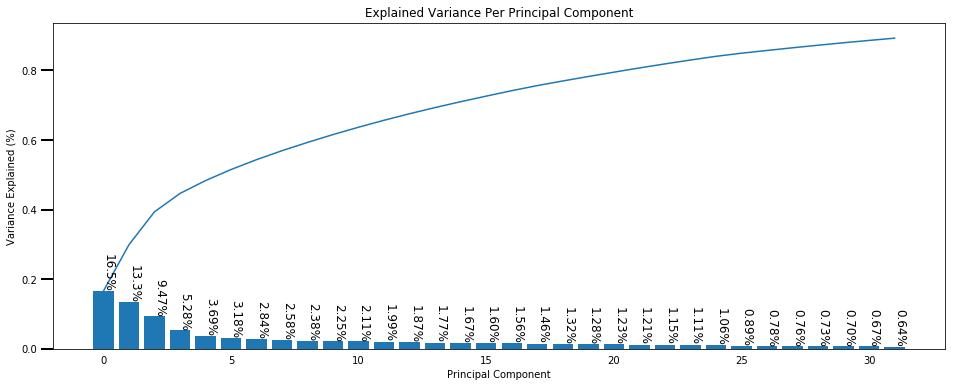

In [40]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), \
                    va="bottom", ha="center", fontsize=12, rotation=270)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca_test)

In [41]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca   = PCA(10)
X_pca = pca.fit_transform(azdias_final)

### Discussion 2.2: Perform Dimensionality Reduction

The cumulative line is rather smooth. I pick the number of components to be 10, which can roughtly exlain 60% of the variation in data. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

PLZ8_ANTG3               0.2253
PLZ8_ANTG4               0.2169
WEALTH                   0.2047
HH_EINKOMMEN_SCORE       0.2022
ORTSGR_KLS9              0.1968
EWDICHTE                 0.1947
FINANZ_HAUSBAUER         0.1595
KBA05_ANTG4              0.1540
PLZ8_ANTG2               0.1537
FINANZ_SPARER            0.1531
ARBEIT                   0.1426
KBA05_ANTG3              0.1367
ANZ_HAUSHALTE_AKTIV      0.1361
RELAT_AB                 0.1350
SEMIO_PFLICHT            0.1211
SEMIO_REL                0.1186
DECADE                   0.1122
MOVEMENT                 0.1102
SEMIO_RAT                0.0995
SEMIO_TRADV              0.0937
SEMIO_MAT                0.0824
SEMIO_FAM                0.0810
FINANZ_UNAUFFAELLIGER    0.0810
SEMIO_KULT               0.0755
FINANZ_ANLEGER           0.0751
REGIOTYP                 0.0603
OST_WEST_KZ              0.0537
SEMIO_SOZ                0.0433
PLZ8_HHZ                 0.0422
HEALTH_TYP               0.0412
                          ...  
SEMIO_DO

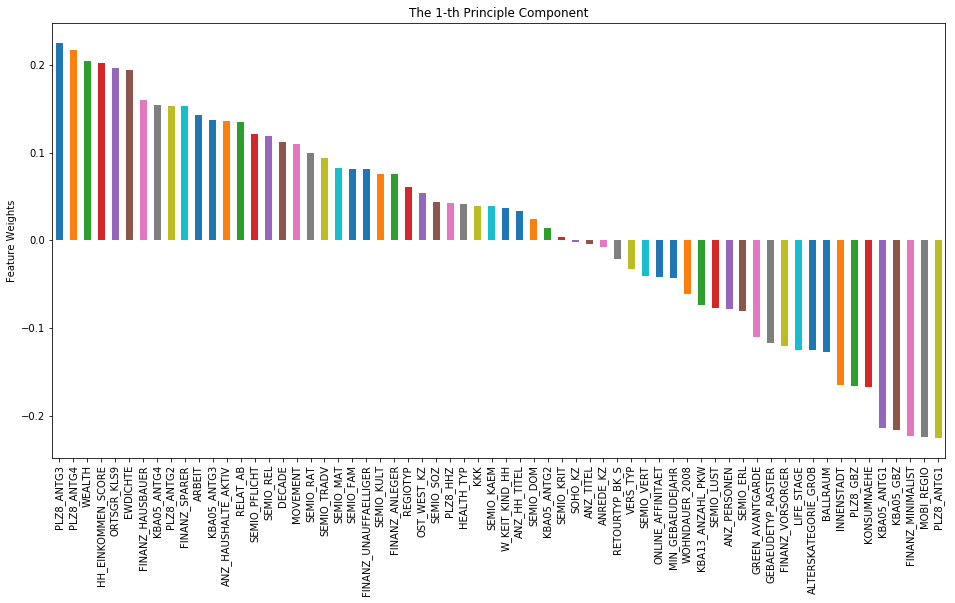

In [42]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(full_dataset, pca, n_th):

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    n_th_component = components.iloc[n_th-1,:].sort_values(ascending=False)
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (16,8))

    # Plot the feature weights as a function of the components
    n_th_component.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_title("The {}-th Principle Component".format(n_th))
    
    return n_th_component

component = pca_results(azdias_final, pca, 1)
print(component)

ALTERSKATEGORIE_GROB     0.2563
SEMIO_ERL                0.2299
FINANZ_VORSORGER         0.2293
SEMIO_LUST               0.1801
RETOURTYP_BK_S           0.1619
FINANZ_HAUSBAUER         0.1218
SEMIO_KRIT               0.1179
SEMIO_KAEM               0.1164
W_KEIT_KIND_HH           0.1148
PLZ8_ANTG3               0.0984
EWDICHTE                 0.0979
ORTSGR_KLS9              0.0965
PLZ8_ANTG4               0.0962
WEALTH                   0.0792
KBA05_ANTG4              0.0752
SEMIO_DOM                0.0745
ARBEIT                   0.0718
RELAT_AB                 0.0693
PLZ8_ANTG2               0.0681
ANZ_HAUSHALTE_AKTIV      0.0664
HH_EINKOMMEN_SCORE       0.0619
FINANZ_MINIMALIST        0.0594
WOHNDAUER_2008           0.0584
KBA05_ANTG3              0.0505
ANZ_HH_TITEL             0.0321
OST_WEST_KZ              0.0275
MOVEMENT                 0.0184
PLZ8_HHZ                 0.0159
REGIOTYP                 0.0119
ANZ_TITEL                0.0068
                          ...  
GREEN_AV

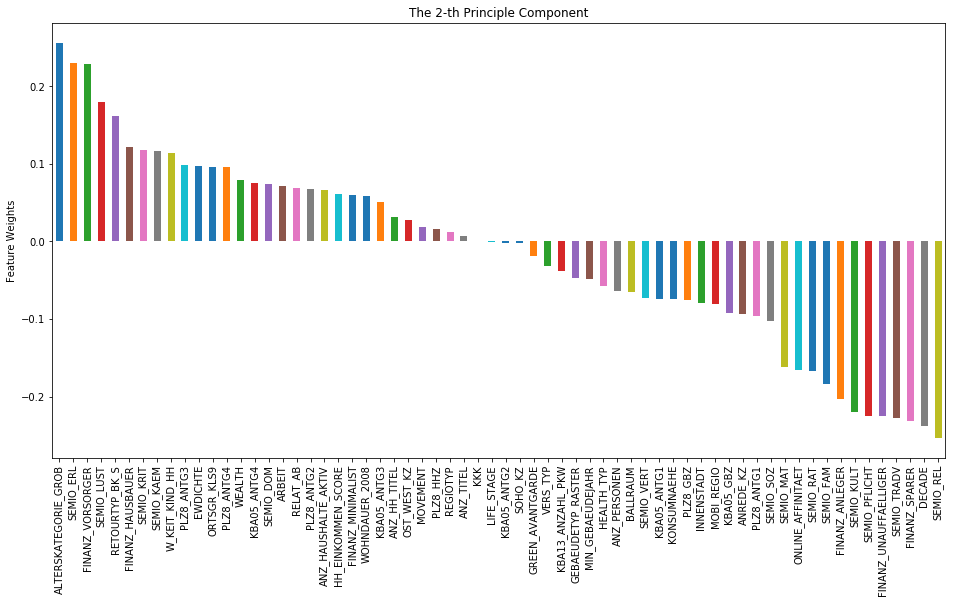

In [43]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component = pca_results(azdias_final, pca, 2)
print(component)

ANREDE_KZ                0.3674
SEMIO_VERT               0.3447
SEMIO_SOZ                0.2619
SEMIO_FAM                0.2489
SEMIO_KULT               0.2339
FINANZ_MINIMALIST        0.1545
RETOURTYP_BK_S           0.1090
FINANZ_VORSORGER         0.1017
W_KEIT_KIND_HH           0.0851
ALTERSKATEGORIE_GROB     0.0796
SEMIO_REL                0.0677
SEMIO_LUST               0.0645
SEMIO_MAT                0.0556
ORTSGR_KLS9              0.0503
EWDICHTE                 0.0495
PLZ8_ANTG4               0.0492
PLZ8_ANTG3               0.0484
GREEN_AVANTGARDE         0.0471
ARBEIT                   0.0373
RELAT_AB                 0.0343
PLZ8_ANTG2               0.0327
WOHNDAUER_2008           0.0326
WEALTH                   0.0302
KBA05_ANTG4              0.0300
ANZ_HAUSHALTE_AKTIV      0.0268
OST_WEST_KZ              0.0163
ANZ_HH_TITEL             0.0139
KBA05_ANTG3              0.0119
ANZ_TITEL                0.0096
PLZ8_HHZ                 0.0056
                          ...  
LIFE_STA

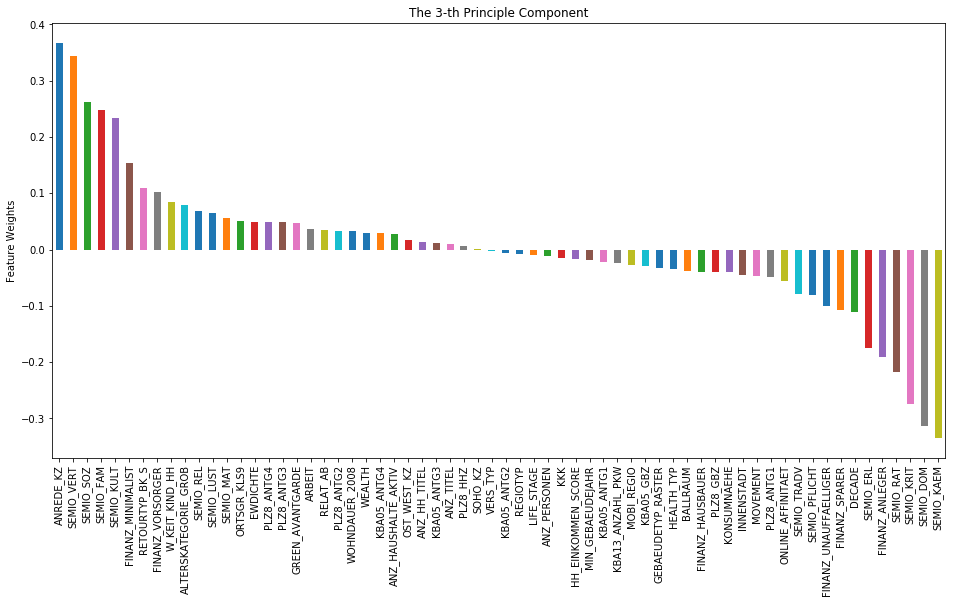

In [44]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

component = pca_results(azdias_final, pca, 3)
print(component)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

1. Component 1: <br>
    The top 3 positive features are `PLZ8_ANTG3`, `PLZ8_ANTG4`, `WEALTH`                 
    The top 3 negative features are `FINANZ_MINIMALIST`, `MOBI_REGIO`, `PLZ8_ANTG1`             
    These variables basically reflect the family size and financail status. Family size and financail status are correlated since poor people may have to live together to split the rent. `MOBI_REGIO` measures the mobility. Large families are less likely to move.
    
2. Component 2: <br>
    The top 3 positive features are `ALTERSKATEGORIE_GROB`, `SEMIO_ERL`, `FINANZ_VORSORGER`                 
    The top 3 negative features are `FINANZ_SPARER`, `DECADE`, `SEMIO_REL`  
    These variables reflect age (`ALTERSKATEGORIE_GROB`, `DECADE`), financial status `FINANZ_*`, and some personality aspects (`SEMIO_*`).

3. Component 3: <br>
    The top 3 positive features are `ANREDE_KZ`, `SEMIO_VERT`, `SEMIO_SOZ`                 
    The top 3 negative features are `SEMIO_KRIT`, `SEMIO_DOM`, `SEMIO_KAEM`  
    This component mainly reflects the personality (`SEMIO_VERT`, `SEMIO_SOZ`, `SEMIO_KRIT`, `SEMIO_DOM`, `SEMIO_KAEM`) and sex (`ANREDE_KZ`). This makes sense as woman (`ANREDE_KZ` = 2) tends to be less aggressive (low values in `SEMIO_KRIT`, `SEMIO_DOM`, `SEMIO_KAEM`) than man (`ANREDE_KZ` = 1). 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [46]:
def get_k_mean_score(data, n):
    kmeans = KMeans(n_clusters = n)
    model  = kmeans.fit(data)
    score  = np.abs(model.score(data))
    return score

from time import time

scores=[]
# Over a number of different cluster counts...
for n in range(2,21):
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    start_time = time()
    scores.append(get_k_mean_score(X_pca, n))
    end_time   = time()
    tot_time   = end_time - start_time
    print('Estimation #{:2} completed.'.format(n))
    print("Total Elapsed Runtime: {:2} mins {:2} seconds".format(int(tot_time/60), int(tot_time%60)))

Estimation # 2 completed.
Total Elapsed Runtime:  0 mins 10 seconds
Estimation # 3 completed.
Total Elapsed Runtime:  0 mins 21 seconds
Estimation # 4 completed.
Total Elapsed Runtime:  0 mins 18 seconds
Estimation # 5 completed.
Total Elapsed Runtime:  0 mins 24 seconds
Estimation # 6 completed.
Total Elapsed Runtime:  0 mins 39 seconds
Estimation # 7 completed.
Total Elapsed Runtime:  0 mins 49 seconds
Estimation # 8 completed.
Total Elapsed Runtime:  1 mins  7 seconds
Estimation # 9 completed.
Total Elapsed Runtime:  1 mins  5 seconds
Estimation #10 completed.
Total Elapsed Runtime:  1 mins 45 seconds
Estimation #11 completed.
Total Elapsed Runtime:  2 mins 20 seconds
Estimation #12 completed.
Total Elapsed Runtime:  2 mins 54 seconds
Estimation #13 completed.
Total Elapsed Runtime:  2 mins 52 seconds
Estimation #14 completed.
Total Elapsed Runtime:  3 mins 10 seconds
Estimation #15 completed.
Total Elapsed Runtime:  3 mins  7 seconds
Estimation #16 completed.
Total Elapsed Runtime:

In [48]:
# start_time = time()
# scores.append(get_k_mean_score(X_pca, 20))
# end_time   = time()
# tot_time   = end_time - start_time
# print('Estimation #{:2} completed.'.format(20))
# print("Total Elapsed Runtime: {:2} mins {:2} seconds".format(int(tot_time/60), int(tot_time%60)))

Estimation #20 completed.
Total Elapsed Runtime:  5 mins 36 seconds


Text(0,0.5,'Score')

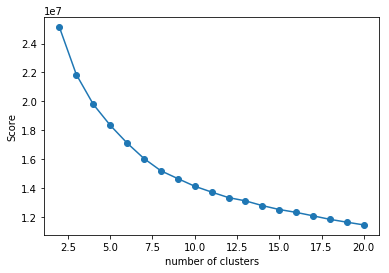

In [51]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(2,21), scores, marker='o', linestyle='-')
plt.xlabel('number of clusters')
plt.ylabel('Score')

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 20)
model  = kmeans.fit(X_pca)
X_pca_pred = model.predict(X_pca)

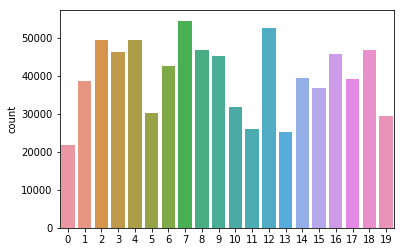

In [75]:
sb.countplot(X_pca_pred)

In [78]:
pd.Series(X_pca_pred).value_counts()

7     54503
12    52523
2     49463
4     49453
8     46792
18    46760
3     46214
16    45841
9     45126
6     42536
14    39344
17    39171
1     38541
15    36923
10    31925
5     30248
19    29455
11    26015
13    25222
0     21782
dtype: int64

### Discussion 3.1: Apply Clustering to General Population

The "elbow" principle does not work well here. I select n = 20.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [79]:
# Load in the customer demographics data.
customers       = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_clean = clean_data(customers)
print(customers_clean.shape)

(141690, 64)


In [80]:
print(set(azdias_final.columns) == set(customers_clean.columns))
customers_clean.isnull().sum().sum()

True


103735

In [81]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean    = imputer.transform(customers_clean)
customers_clean    = scaler.transform(customers_clean)

In [82]:
customers_pca      = pca.transform(customers_clean)
customers_pca_pred = model.predict(customers_pca)

In [83]:
pd.Series(customers_pca_pred).value_counts()

6     48440
16    18905
17    17575
12    10273
9      7603
7      7356
2      5153
5      4614
10     4577
18     4294
0      3460
1      2104
3      1502
15     1453
14     1311
4      1022
8       853
19      704
13      320
11      171
dtype: int64

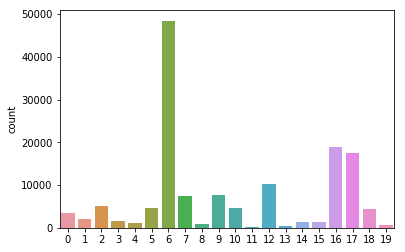

In [84]:
sb.countplot(customers_pca_pred)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Customer Clusters')

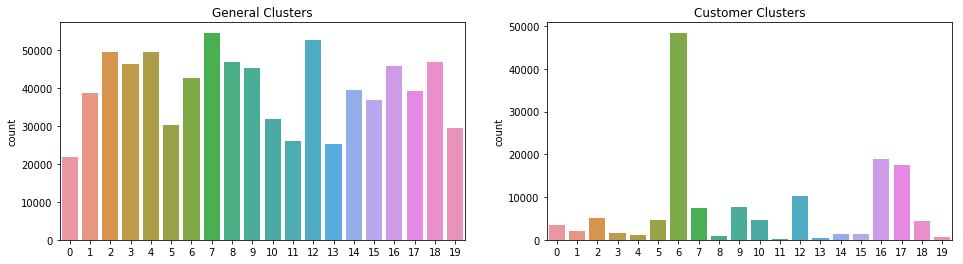

In [85]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (16,4))

sb.countplot(X_pca_pred, ax=axs[0])
axs[0].set_title('General Clusters')

sb.countplot(customers_pca_pred, ax=axs[1])
axs[1].set_title('Customer Clusters')

Adding those who were dropped as **Cluster 20**

In [86]:
customer_cluster = pd.Series(customers_pca_pred).value_counts()
customer_cluster.sort_index(inplace=True)
customer_cluster[20] = len(customers) - len(customers_pca_pred)

general_cluster = pd.Series(X_pca_pred).value_counts()
general_cluster.sort_index(inplace=True)
general_cluster[20] = len(azdias) - len(X_pca_pred)

Text(0.5,1,'Customer Clusters')

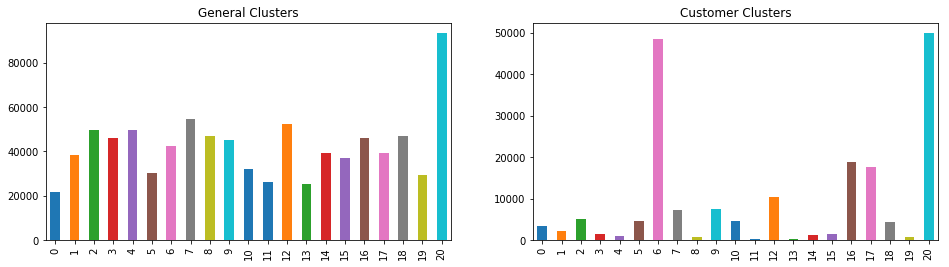

In [87]:
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (16,4))

general_cluster.plot(kind='bar',ax=axs[0])
axs[0].set_title('General Clusters')

customer_cluster.plot(kind='bar',ax=axs[1])
axs[1].set_title('Customer Clusters')

In [88]:
representation_rate = pd.Series([ x/y*100 for x,y in zip(customer_cluster, general_cluster)])
representation_rate.sort_values(ascending=False)

6     113.880008
20     53.501671
17     44.867376
16     41.240374
12     19.559050
9      16.848380
0      15.884675
5      15.253901
10     14.336727
7      13.496505
2      10.417888
18      9.183062
1       5.459121
15      3.935217
14      3.332147
3       3.250097
19      2.390087
4       2.066609
8       1.822961
13      1.268734
11      0.657313
dtype: float64

It can be seen that 
- cluster 6 is the most overrepresented and 
- cluster 11 is the most underrepresented

In [89]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# group6 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[6]))

### keeping scaled helps indentify its relative position in the population 
group6 = pca.inverse_transform(model.cluster_centers_[6])
group6 = pd.Series(group6, index = azdias_clean.columns).sort_values()
print("Top three below/above average features:")
print("---------------------------------------")
print(group6[[0,1,2,-3,-2,-1]])

Top three below/above average features:
---------------------------------------
FINANZ_SPARER       -1.049846
SEMIO_KAEM          -0.996656
EWDICHTE            -0.994954
FINANZ_VORSORGER     0.926631
SEMIO_VERT           0.936328
FINANZ_MINIMALIST    1.164847
dtype: float64


In [90]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# group11 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[11]))

### keeping scaled helps indentify its relative position in the population 
group11 = pca.inverse_transform(model.cluster_centers_[11])
group11 = pd.Series(group11, index = azdias_clean.columns).sort_values()
print("Top three below/above average features:")
print("---------------------------------------")
print(group11[[0,1,2,-3,-2,-1]])

Top three below/above average features:
---------------------------------------
MOVEMENT             -1.261206
HH_EINKOMMEN_SCORE   -1.088987
ANREDE_KZ            -0.983458
ONLINE_AFFINITAET     1.034217
SEMIO_DOM             1.064746
GREEN_AVANTGARDE      1.261206
dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

- cluster  6 is the most overrepresented
    - compared to the population, it has low 
        1. `FINANZ_SPARER`, i.e. high saver
        2. `SEMIO_KAEM`, i.e. not combative
        3. `EWDICHTE`, i.e. living in a area with low population density
    - compared to the population, it has high 
        1. `FINANZ_VORSORGER`, i.e. financially not prepared
        2. `SEMIO_VERT`, i.e. very dreamful
        3. `FINANZ_MINIMALIST`. i.e. very low financial interest
- cluster 11 is the most underrepresented
    - compared to the population, it has low 
        1. `MOVEMENT`, i.e. more likely to be Avantgarde
        2. `HH_EINKOMMEN_SCORE`, i.e. high income
        3. `ANREDE_KZ`, i.e. male
    - compared to the population, it has high 
        1. `ONLINE_AFFINITAET`, 
        2. `SEMIO_DOM`, i.e. very dominant-minded
        3. `GREEN_AVANTGARDE`, i.e. likely to be a member of green avantgarde

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.